# Blackbird Rotation Angles

The overall rotation angles is given by the camera system but the rates for quaternions can be estimated from the gryoscope values from the IMU. It appears that fitting polynomials to the noisy quaternion data is 

## Importation of Data

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import sys

# sys.path.append(os.path.abspath('../functions'))
from thesis.data import blackbird_dataset as rbd
from thesis.modules import dsp

test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)

In [2]:
# Figure formatting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216365 entries, 1526617312016142000 to 1526617526753759000
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PWM1                            39823 non-null  float64
 1   PWM2                            39823 non-null  float64
 2   PWM3                            39823 non-null  float64
 3   PWM4                            39823 non-null  float64
 4   angular_velocity_covariance     21298 non-null  object 
 5   ax_[m/s2]                       21298 non-null  float64
 6   ay_[m/s2]                       21298 non-null  float64
 7   az_[m/s2]                       21298 non-null  float64
 8   linear_acceleration_covariance  21298 non-null  object 
 9   omegax_[dps]                    21298 non-null  float64
 10  omegay_[dps]                    21298 non-null  float64
 11  omegaz_[dps]                    21298 non-null  float64
 12 

In [4]:
rbts2s = 10 ** -9
rtd = 180.0/np.pi

subset_df = test_df[['qw','qx','qy','qz',\
                  'roll_[rad]', 'pitch_[rad]', 'yaw_[rad]']]

subset_df = subset_df.dropna()
tvec = (subset_df.index - test_df.index[0])*rbts2s
tvec = tvec.astype('float')


## Consistency of Quaternion Solution

In [5]:
fig, ax = plt.subplots(1,1)

ax.plot(tvec, subset_df['roll_[rad]']*rtd, label="Roll ($\phi$) [deg]")
ax.plot(tvec, subset_df['pitch_[rad]']*rtd, label="Pitch ($\\theta$) [deg]")
ax.plot(tvec, subset_df['yaw_[rad]']*rtd, label="Yaw ($\psi$) [deg]")

plt.legend()

plt.show()

<IPython.core.display.Javascript object>

In [6]:
fig, ax = plt.subplots(1,1)

ax.plot(tvec, subset_df['qw'].values, label="$q_0$")
ax.plot(tvec, subset_df['qx'].values, label="$q_1$")
ax.plot(tvec, subset_df['qy'].values, label="$q_2$")
ax.plot(tvec, subset_df['qz'].values, label="$q_3$")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [7]:
def quaternion_solution_check(qn1, qn):
    """
    Summary: Returns most likely quaternion solution between the positive rotation angle and is negative rotation angle. 
    Metric to decide is the minimization of the L2 norm.
    
    Parameters:
        * q is a quaternion of [q0, q1, q2, q3] in a list
        * qn1 is the previous timestep quaternion
        * qn is the current timestep quaternion
    """
    #Make opposite quaternion
    neg_qn = [-1*qi for qi in qn]
    
    #Scoring based off L2 norm since update rate is so high
    sp = 0
    sn = 0
    for qn1_i, qn_i, neg_qn_i in zip(qn1, qn, neg_qn):
        sp += (qn1_i - qn_i) ** 2
        sn += (qn1_i - neg_qn_i) ** 2
    #Return most likely
    if sn < sp:
        #print("switched")
        return neg_qn
    else:
        return qn

print(quaternion_solution_check([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5]))
print(quaternion_solution_check([0.5, 0.5, 0.5, 0.5], [-0.5, -0.5, -0.5, -0.5]))
print(quaternion_solution_check([0.5, 0.5, 0.5, 0.5], [0.5, -0.5, -0.5, 0.5]))

[0.5, 0.5, 0.5, 0.5]
[0.5, 0.5, 0.5, 0.5]
[0.5, -0.5, -0.5, 0.5]


In [8]:
#Preallocate Quaternion list
qn1 = [None]*4
qn  = [None]*4

qvec = subset_df[['qw', 'qx', 'qy', 'qz']].values

for i in range(1,len(qvec)):
    qvec[i] = quaternion_solution_check(qvec[i-1], qvec[i])

subset_df[['qw', 'qx', 'qy', 'qz']] = qvec

In [9]:
fig, ax = plt.subplots(1,1)

ax.plot(tvec, subset_df['qw'].values, label="$q_0$")
ax.plot(tvec, subset_df['qx'].values, label="$q_1$")
ax.plot(tvec, subset_df['qy'].values, label="$q_2$")
ax.plot(tvec, subset_df['qz'].values, label="$q_3$")

plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## Filtering of Quaternion Solution

In [10]:
mq = 5
wq = 25

qw_dot = dsp.central_sg_filter(tvec, subset_df['qw'].values, m=mq, window=wq)
qx_dot = dsp.central_sg_filter(tvec, subset_df['qx'].values, m=mq, window=wq)
qy_dot = dsp.central_sg_filter(tvec, subset_df['qy'].values, m=mq, window=wq)
qz_dot = dsp.central_sg_filter(tvec, subset_df['qz'].values, m=mq, window=wq)

qw = qw_dot[:,0]
qx = qx_dot[:,0]
qy = qy_dot[:,0]
qz = qz_dot[:,0]

qw_dot = qw_dot[:,1]
qx_dot = qx_dot[:,1]
qy_dot = qy_dot[:,1]
qz_dot = qz_dot[:,1]

In [11]:
fig,ax = plt.subplots(4,1)

ax[0].plot(tvec, qw_dot)
ax[1].plot(tvec, qx_dot)
ax[2].plot(tvec, qy_dot)
ax[3].plot(tvec, qz_dot)

plt.show()

<IPython.core.display.Javascript object>

## Agreement of Quaternions and IMU Gyroscope

In [12]:
def Wq(q0, q1, q2, q3):
    """W matrix"""
    return np.array([[-q1,  q0, -q3,  q2],
                     [-q2,  q3,  q0, -q1],
                     [-q3, -q2,  q1,  q0]])

def Wq_prime(q0, q1, q2, q3):
    """W matrix"""
    return np.array([[-q1,  q0,  q3, -q2],
                     [-q2, -q3,  q0,  q1],
                     [-q3,  q2, -q1,  q0]])

def Omega_from_quaternions(qvec, qdotvec):
    """
    Omega vector from quaternions
    
    Inputs:
        * qvec:    4 element list with (q_0, q_1-3) convention
        * qdotvec: 4 element list of temperal derivative of qvec
    Output:
        * omega: 3 element list of (wx, wy, wz)
    """
    W = Wq(qvec[0], qvec[1], qvec[2], qvec[3])
    omega = 2*np.matmul(W, np.array(qdotvec, ndmin=2).transpose()).transpose()[0]
    return omega

def Omega_from_quaternions_alt(qvec, qdotvec):
    """
    Omega vector from quaternions
    
    Inputs:
        * qvec:    4 element list with (q_0, q_1-3) convention
        * qdotvec: 4 element list of temperal derivative of qvec
    Output:
        * omega: 3 element list of (wx, wy, wz)
    """
    W = Wq_prime(qvec[0], qvec[1], qvec[2], qvec[3])
    omega = 2*np.matmul(W, np.array(qdotvec, ndmin=2).transpose()).transpose()[0]
    return omega

qvec    = [0, 1, 0, 0]
qdotvec = [0, 1, 1, 0]
print(Wq(qvec[0], qvec[1], qvec[2], qvec[3]))
print(Omega_from_quaternions(qvec, qdotvec))

[[-1  0  0  0]
 [ 0  0  0 -1]
 [ 0  0  1  0]]
[0 0 2]


In [13]:
#Getting roll rates over experiment

n = len(qw_dot)

P = np.zeros(n)
P_alt = np.zeros(n)
Q = np.zeros(n)
Q_alt = np.zeros(n)
R = np.zeros(n)
R_alt = np.zeros(n)

for i in range(n):
    omega = Omega_from_quaternions([qw[i], qx[i], qy[i], qz[i]], 
                                   [qw_dot[i], qx_dot[i], qy_dot[i], qz_dot[i]])
    omega_alt = Omega_from_quaternions_alt([qw[i], qx[i], qy[i], qz[i]], 
                                           [qw_dot[i], qx_dot[i], qy_dot[i], qz_dot[i]])
    P[i] = omega[0]
    Q[i] = omega[1]
    R[i] = omega[2]
    P_alt[i] = omega_alt[0]
    Q_alt[i] = omega_alt[1]
    R_alt[i] = omega_alt[2]

In [14]:
#Plotting the results
fig,ax = plt.subplots(3,1)

ax[0].plot(tvec, P, color='r')
ax[1].plot(tvec, Q, color='g')
ax[2].plot(tvec, R, color='b')

plt.show()

<IPython.core.display.Javascript object>

In [15]:
#Plotting the Alternative results
fig,ax = plt.subplots(3,1)

ax[0].plot(tvec, P_alt, color='r')
ax[1].plot(tvec, Q_alt, color='g')
ax[2].plot(tvec, R_alt, color='b')

plt.show()

<IPython.core.display.Javascript object>

In [16]:
# Getting IMU values to comparison
imu_rates = test_df[['omegax_[dps]', 'omegay_[dps]', 'omegaz_[dps]']].dropna()
t_imu = (imu_rates.index - test_df.index[0])*rbts2s
t_imu = t_imu.astype('float')

In [17]:
#Plotting against the IMU
fig,ax = plt.subplots(3,1)

ax[0].plot(tvec, P, color='#990000', linestyle="None", marker='.')
ax[0].plot(t_imu, imu_rates['omegax_[dps]'], color='r', linestyle="None", marker='x')
ax[1].plot(tvec, Q, color='#009900', linestyle="None", marker='.')
ax[1].plot(t_imu, imu_rates['omegay_[dps]'], color='g', linestyle="None", marker='x')
ax[2].plot(tvec, R, color='#000099', linestyle="None", marker='.')
ax[2].plot(t_imu, imu_rates['omegaz_[dps]'], color='b', linestyle="None", marker='x')

plt.show()

<IPython.core.display.Javascript object>

In [18]:
#Plotting against the IMU
fig,ax = plt.subplots(3,1)

ax[0].plot(tvec, P_alt, color='#990000', linestyle="None", marker='.')
ax[0].plot(t_imu, imu_rates['omegax_[dps]'], color='r', linestyle="None", marker='x')
ax[1].plot(tvec, Q_alt, color='#009900', linestyle="None", marker='.')
ax[1].plot(t_imu, imu_rates['omegay_[dps]'], color='g', linestyle="None", marker='x')
ax[2].plot(tvec, R_alt, color='#000099', linestyle="None", marker='.')
ax[2].plot(t_imu, imu_rates['omegaz_[dps]'], color='b', linestyle="None", marker='x')

plt.show()

<IPython.core.display.Javascript object>

In [19]:
#Plotting against the IMU with installation correction with rates from quaternions
fig,ax = plt.subplots(3,1)

ax[0].plot(tvec, P, color='#990000', linestyle="None", marker='.')
ax[0].plot(t_imu, -1.0*imu_rates['omegay_[dps]'], color='r', linestyle="None", marker='x')
ax[1].plot(tvec, Q, color='#009900', linestyle="None", marker='.')
ax[1].plot(t_imu, imu_rates['omegax_[dps]'], color='g', linestyle="None", marker='x')
ax[2].plot(tvec, R, color='#000099', linestyle="None", marker='.')
ax[2].plot(t_imu, imu_rates['omegaz_[dps]'], color='b', linestyle="None", marker='x')

plt.show()

<IPython.core.display.Javascript object>

In [20]:
#Plotting against the IMU with installation correction with rates from quaternions
fig,ax = plt.subplots(3,1)

ax[0].plot(tvec, P_alt, color='#990000', linestyle="None", marker='.')
ax[0].plot(t_imu, -1.0*imu_rates['omegay_[dps]'], color='r', linestyle="None", marker='x')
ax[1].plot(tvec, Q_alt, color='#009900', linestyle="None", marker='.')
ax[1].plot(t_imu, imu_rates['omegax_[dps]'], color='g', linestyle="None", marker='x')
ax[2].plot(tvec, R_alt, color='#000099', linestyle="None", marker='.')
ax[2].plot(t_imu, imu_rates['omegaz_[dps]'], color='b', linestyle="None", marker='x')

plt.show()

<IPython.core.display.Javascript object>

### Data Agreement Conclusions

Since the polynomial fits on the quaternions seem to be consistent with the IMU gyroscope readings, the quaternions by the camera system is likely sufficiently accurate for rotating accelerations into frame.

## Spectral Content

This is to look at the major modes associated with both the IMU and the Camera system to try and identify any special modes. The current suspicion is that the balls on the end on the extensions are being influenced by a structural/aero-structural/aerodynamical dynamical mode. The decided methodology is to use a discrete fourier transform as on [wikipedia](https://en.wikipedia.org/wiki/Discrete_Fourier_transform)

$$ X_k = \sum_{n=0}^{N-1} x_n\cdot e^{-\frac{i2\pi}{N}kn} =  \sum_{n=0}^{N-1} x_n \left[ \cos \left(\frac{2\pi}{N}kn\right) - i\cdot \sin \left(\frac{2\pi}{N}kn\right) \right]$$

There are a couple things that will be adjusted though to account for the time series not being an even time stamp. The nominal window that will be what was observed which is around 225 seconds so the lowest frequency ($f_1$) observed will be $\approx$0.005 Hz. A  positive vector of frequencies shall be constructed by doublings of the previous frequencies provided 190 Hz is not exceeded. From the positive frequency, a negative frequency can also be constructed which represents the opposite rotation direction. However, since the angular rates is simply a real vector, than a only one frequency direction has to be observed so some simplicity and be found. The magnitude of the fourier coefficient is simply the following.

$$ |X_k| = \sqrt{Re(X_k)^2 + Im(X_k)^2} $$

In [21]:
#Set up for frequency vector
Fs = 360.0 #Sampling Frequency
N = len(tvec)
fvec = Fs*np.arange(N/2)/N

In [22]:
# Set up fourier transform coefficient matrices
p_f = np.zeros(len(fvec), dtype=complex)
q_f = np.zeros(len(fvec), dtype=complex)
r_f = np.zeros(len(fvec), dtype=complex)

#Imaginary component
z = 1j

for i in range(len(P_alt)):
    #print(tvec[i])
    #Iterate through frequency
    # Preallocate the sine and cosine components
    c = np.cos(2*np.pi*fvec*tvec[i])
    s = np.sin(2*np.pi*fvec*tvec[i])
        
    # Calculate additional part to it
    p_f = p_f + (P_alt[i] + 0*z)*(c - z*s)
    q_f = q_f + (Q_alt[i] + 0*z)*(c - z*s)
    r_f = r_f + (R_alt[i] + 0*z)*(c - z*s)

In [23]:
pmag = np.zeros(len(fvec))
qmag = np.zeros(len(fvec))
rmag = np.zeros(len(fvec))

for i in range(len(fvec)):
    pmag[i] = np.sqrt(np.real(p_f[i]) ** 2 + np.imag(p_f[i]) ** 2)
    qmag[i] = np.sqrt(np.real(q_f[i]) ** 2 + np.imag(q_f[i]) ** 2)
    rmag[i] = np.sqrt(np.real(r_f[i]) ** 2 + np.imag(r_f[i]) ** 2)

In [24]:
#Linear response scale
fig,ax = plt.subplots(3,1)

ax[0].plot(fvec, pmag, color='r')
ax[1].plot(fvec, qmag, color='g')
ax[2].plot(fvec, rmag, color='b')

plt.show()

<IPython.core.display.Javascript object>

In [25]:
#Log response scale
fig,ax = plt.subplots(3,1)

ax[0].plot(fvec, pmag, color='r')
ax[0].set_title('One Sided Power Response')
ax[0].set_ylabel('$|\hat{P}|$')
ax[1].plot(fvec, qmag, color='g')
ax[1].set_ylabel('$|\hat{Q}|$')
ax[2].plot(fvec, rmag, color='b')
ax[2].set_ylabel('$|\hat{R}|$')

for a in ax:
    a.set_xlabel('Frequency ($f$) [Hz]')
    a.set_xscale('log')
    a.set_yscale('log')

plt.show()

<IPython.core.display.Javascript object>

In [26]:
#Set up IMU frequency vector
Fs = 100.0 #Sampling Frequency
N = len(t_imu)
fvec_imu = Fs*np.arange(N/2)/N

P_imu = -1.0*imu_rates['omegay_[dps]'].values
Q_imu = imu_rates['omegax_[dps]'].values
R_imu = imu_rates['omegaz_[dps]'].values

In [27]:
# Set up fourier transform coefficient matrices
p_f_imu = np.zeros(len(fvec_imu), dtype=complex)
q_f_imu = np.zeros(len(fvec_imu), dtype=complex)
r_f_imu = np.zeros(len(fvec_imu), dtype=complex)

#Imaginary component
z = 1j

for i in range(len(P_imu)):
    #print(tvec[i])
    #Iterate through frequency
    # Preallocate the sine and cosine components
    c = np.cos(2*np.pi*fvec_imu*tvec[i])
    s = np.sin(2*np.pi*fvec_imu*tvec[i])
        
    # Calculate additional part to it
    p_f_imu = p_f_imu + (P_imu[i] + 0*z)*(c - z*s)
    q_f_imu = q_f_imu + (Q_imu[i] + 0*z)*(c - z*s)
    r_f_imu = r_f_imu + (R_imu[i] + 0*z)*(c - z*s)

In [28]:
pmag_imu = np.zeros(len(fvec_imu))
qmag_imu = np.zeros(len(fvec_imu))
rmag_imu = np.zeros(len(fvec_imu))

for i in range(len(fvec_imu)):
    pmag_imu[i] = np.sqrt(np.real(p_f_imu[i]) ** 2 + np.imag(p_f_imu[i]) ** 2)
    qmag_imu[i] = np.sqrt(np.real(q_f_imu[i]) ** 2 + np.imag(q_f_imu[i]) ** 2)
    rmag_imu[i] = np.sqrt(np.real(r_f_imu[i]) ** 2 + np.imag(r_f_imu[i]) ** 2)

In [29]:
#Linear response scale
fig,ax = plt.subplots(3,1)

ax[0].plot(fvec_imu, pmag_imu, color='r')
ax[1].plot(fvec_imu, qmag_imu, color='g')
ax[2].plot(fvec_imu, rmag_imu, color='b')

plt.show()

<IPython.core.display.Javascript object>

In [30]:
#Log response scale
fig,ax = plt.subplots(3,1)

ax[0].plot(fvec_imu, pmag_imu, color='r')
ax[0].set_title('One Sided Power Response')
ax[0].set_ylabel('$|\hat{P}|$')
ax[1].plot(fvec_imu, qmag_imu, color='g')
ax[1].set_ylabel('$|\hat{Q}|$')
ax[2].plot(fvec_imu, rmag_imu, color='b')
ax[2].set_ylabel('$|\hat{R}|$')

for a in ax:
    a.set_xlabel('Frequency ($f$) [Hz]')
    a.set_xscale('log')
    a.set_yscale('log')

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


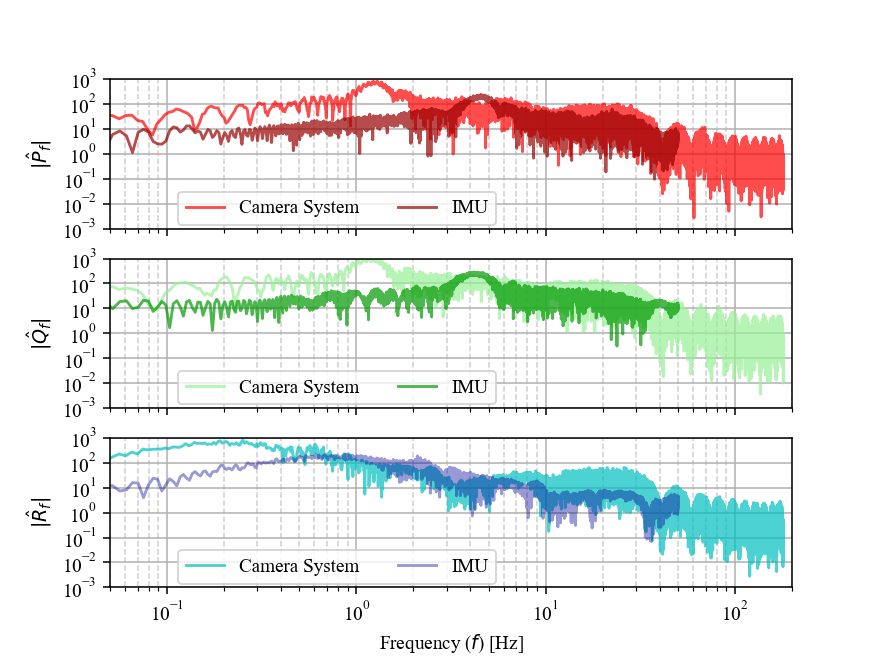

In [41]:
#Log response scale
fig,ax = plt.subplots(3,1, sharex=True)

ax[0].plot(fvec, pmag, color='r', alpha=0.7, label='Camera System')
ax[0].plot(fvec_imu, pmag_imu, color='#990000', alpha=0.7, label='IMU')
#ax[0].set_title('One Sided Power Response Comparison')
ax[0].set_ylabel('$|\hat{P}_f|$')
ax[1].plot(fvec, qmag, color='#98F098', alpha=0.7, label='Camera System')
ax[1].plot(fvec_imu, qmag_imu, color='#009900', alpha=0.7, label='IMU')
ax[1].set_ylabel('$|\hat{Q}_f|$')
ax[2].plot(fvec, rmag, color='c', alpha=0.7, label='Camera System')
ax[2].plot(fvec_imu, rmag_imu, color='#000099', alpha=0.4, label='IMU')
ax[2].set_ylabel('$|\hat{R}_f|$')
ax[2].set_xlabel('Frequency ($f$) [Hz]')

for a in ax:
    #a.set_xlabel('Frequency ($f$) [Hz]')
    a.set_xscale('log')
    a.set_yscale('log')
    
    a.set_xlim(0.05, 200)
    a.set_ylim(0.001, 1000)

    a.xaxis.set_major_locator(ticker.LogLocator(base=10, numticks=50))
    a.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=30))
    
    a.grid(True, which='major')
    a.grid(True, which='minor', linestyle='--', alpha=0.6)
    
    a.legend(
        loc=(0.1, 0.025),
        ncol=2,
    )
    
fig.savefig("../report/project-report/figures/pow/sensors-opsd.png")
    
plt.show()

## Fast Fourier Transform Testing

This is simply testing the fast fourier implementations in dsp.py so that it is repeatable.

In [ ]:
import time

def FFT(tvec, X, Fs):
    """
    Description:
    Inputs:
        * tvec = 1xN time vector
        * X    = NxM matrix of time domain values
        * Fs   = Sample frequency
    Outputs:
        * fvec = 1xNf vector of frequencies
        * Xf   = NfxM matrix of frequency coefficients
    """
    #Set up for frequency vector
    N = len(tvec)
    if len(X.shape) == 1:
        M = 0
    else:
        M = X.shape[1]
    
    fvec = Fs*np.arange(-N/2,N/2)/N #Both negative and positive frequencies
    
    #Set up preallocation of results
    Nf = len(fvec)
    if M == 0:
        Xf = np.zeros((Nf,), dtype=complex)
    else:
        Xf = np.zeros((Nf,M), dtype=complex)
    
    #Imaginary unit
    z = 1j

    #Loop through time vector
    for i in range(N):
        #Iterate through frequency
        # Preallocate the sine and cosine components
        c = np.cos(2*np.pi*fvec*tvec[i]) #1xNf
        s = np.sin(2*np.pi*fvec*tvec[i]) #1xNf
        
        # Calculate additional part to it
        if M == 0:
            Xf = Xf + (c - z*s)*(X[i] + 0*z)
        else:
            Xf = Xf + np.matmul(np.transpose(c - z*s), X[i,:] + 0*z)
        #NfxM = NfxM + (1xNf)'*(1xM)

    return (fvec, Xf)

start_time = time.perf_counter()
P_input = P_alt#np.reshape(P_alt, (len(P_alt),1))
f, Xf = FFT(tvec, P_input, 360.0)
print(f.shape)
print(Xf.shape)
print("Time elapsed: %f" % (time.perf_counter() - start_time)) #Probably faster if I did this in C/C++